# Perceptual learning in children with autism spectrum disorder (ASD) aka the fishing experiment
**Researchers: Sander Van de Cruys, Lisa Lemmens, Laurie-Anne Sapey-Triomphe, Ilse Noens, Johan Wagemans**
___


See task,  procedure and participant description in the [Manuscript draft](https://docs.google.com/document/d/1c6YqDHVXnDOWc-UlmezoIzxbPWXUFcKpZEnhcbZ8Nnc/edit?usp=sharing)


Notes:

* Warning: This is a working document, and may contain coding or reasoning errors...
* Is er een plot om aan te tonen dat de ASD groep de inferred mean ook slechter/trager geleerd hebben na (of tijdens) blok 4, of kan ik dat al terugzien in één van je plots? Ik zie overigens dat Berniker zelfs bins van maar 10 trials gebruikt om r (gain/slope) en MuP (inferred prior mean) te schatten en de evolutie daarvan te plotten. Is waarschijnlijk ook mogelijk dan?


<img src="img/task.png" style="height:800px">


Importing required python libraries:

In [2]:
import numpy as np
import matplotlib as mpl
import glob, os #to work with paths
import matplotlib.pyplot as plt # roughly ~base R plotting functionality
import pandas as pd #roughly ~base R & tidyr functionality 
import seaborn as sns #roughly ~ggplot2 functionality
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import ptitprince as pt # python version of rain cloud plots
import pingouin as pg # statistical tests
warnings.filterwarnings('ignore')

#to make the plots appear inline, and saved in notebook:
%matplotlib inline
sns.set_context("talk") # seaborn function to make plots according to purpose (talk, paper, poster, notebook)

# We'll show people what versions we use
import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)
import IPython
print(IPython.sys_info())
!pip freeze | grep -E 'seaborn|matplotlib|pandas|statsmodels|pingouin'

Ran on 2019-08-20T17:41:29.105285
{'commit_hash': '741169a00',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.7/dist-packages/IPython',
 'ipython_version': '7.7.0',
 'os_name': 'posix',
 'platform': 'Linux-5.0.0-23-generic-x86_64-with-Ubuntu-19.04-disco',
 'sys_executable': '/usr/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.7.3 (default, Apr  3 2019, 05:39:12) \n[GCC 8.3.0]'}
matplotlib==3.1.1
pandas==0.25.0
pingouin==0.2.8
seaborn==0.9.0
statsmodels==0.10.1


In [108]:
# importing data
df = pd.DataFrame()    
all_files = glob.glob(os.path.join('data',"exp_*.csv")) # get list of individual data files
all_files.sort()

import re 

for file in all_files:
    idcode = re.findall('\d+', file)[0]
    if idcode in ['002','304','315','316','321','322']: continue
    dfnew = pd.read_csv(file, index_col=0).assign(id=int(idcode)) #read file and add column for id
    df = pd.concat([df, dfnew], ignore_index=True)



df['group'] = np.where(df['id']<100, 'ASD', 'TD')

#remove practice trials
df = df[(df.block_index > -1)]
df["id"] = df["id"].astype('category')
df["trial_sigma"] = df["trial_sigma"].astype('category')
df['final'] = np.where(df['final_ori']>180, df['final_ori'] - 360, df['final_ori'])  #variable final, goes from -180 to +180, in line with presented orientations ( -28° to 118°) instead of final_ori that goes from 0 to 360 degrees 



df.head()

,block_index,block_trial,block_mu,block_sigma,trial_mu_deviation,trial_mu,trial_sigma,trial_mean,initial_ori,final_ori,rt,id,group,final
8,0,0,22,20,-10,32,40,0.613132,0,342.6,3.916931,1,ASD,-17.4
9,0,1,22,20,-40,62,40,1.059317,26,54.1,2.883790,1,ASD,54.1
10,0,2,22,20,-20,42,10,0.731784,146,44.5,4.117152,1,ASD,44.5
11,0,3,22,20,-20,42,10,0.716934,39,47.6,2.400319,1,ASD,47.6
12,0,4,22,20,10,12,40,0.316734,47,287.8,2.583609,1,ASD,-72.2


In [70]:
print('Variables:\n', df.columns)
print('variables:\n', df.dtypes)
print('nb of participants:', len(df['id'].unique()))
print('trials per participant:', len(df)/ len(df['id'].unique())) #not exactly
df.groupby('group')['id'].nunique()

Variables:
 Index(['block_index', 'block_trial', 'block_mu', 'block_sigma',
       'trial_mu_deviation', 'trial_mu', 'trial_sigma', 'trial_mean',
       'initial_ori', 'final_ori', 'rt', 'id', 'group', 'final'],
      dtype='object')
variables:
 block_index              int64
block_trial              int64
block_mu                 int64
block_sigma              int64
trial_mu_deviation       int64
trial_mu                 int64
trial_sigma           category
trial_mean             float64
initial_ori              int64
final_ori              float64
rt                     float64
id                    category
group                   object
final                  float64
dtype: object
nb of participants: 49
trials per participant: 400.0


group
ASD    24
TD     25
Name: id, dtype: int64

### Explanation of the data variables

- trial_index = number of trials
- block_index = number of blocks (8 blocks in total, block -1 is practice block)
- block_trial = number of trials within blocks
- block_mu = mean orientation of the prior within a block (same first 6 blocks)
- block_sigma = standard deviation of prior within a block (always 20°)
- trial_mu_deviation = deviation mean orientation from mean of prior
- trial_mu = mean orientation of distribution from with the directions of moving dots are sampled per trial
- trial_sigma = variability of moving dots per trial (10 or 40°)
- trial_mean = actual mean orientation of moving dots per trial
- initial_ori = initial orientation of the fishing rod
- final_ori = response
- rt


In [109]:
#create factor variables for means of priors

# prior_mean is factor variable for mean of prior
df['prior_mean'] = np.where(df['block_mu'] == 22, 22, 68)

# Session variable indicates whether the first prior was the one with 22 mean or 68 mean.
df['session'] = np.where(((df.block_mu == 22) & (df.block_index.isin([0,1,2,3,4,5]))) | ((df.block_mu == 68) & (df.block_index.isin([6,7]))) , "22_first", "68_first")

#Create factor variable for blocks of 100 trials
def blocks(series):
    if series < 2:
        return "1"
    elif 1 < series < 4:
        return "2"
    elif 3 < series < 6:
        return "3"
    elif series > 5:
        return "4"

df['tr_100'] = df['block_index'].apply(blocks)

#Create factor variable to indicate whether it is the first or the second prior
df['prior'] = np.where((df.block_index < 6), "prior 1", "prior 2") #prior 1 or prior 2


## Adding key computed variables

In [110]:

#distance_prior_response is the final chosen direction minus mean of the prior in that block; distance_prior is the presented motion direction minu the mean of the prior in that block. 
df['distance_prior_response'] = df.final - df.block_mu
df['distance_prior'] = df.trial_mu - df.block_mu 
df['distance_prior_response'] = np.where((df.distance_prior_response > 180), df.distance_prior_response - 360, df.distance_prior_response)
df['distance_prior_response'] = np.where((df.distance_prior_response < -180), df.distance_prior_response + 360, df.distance_prior_response)
df['bias']= df.distance_prior_response - df.distance_prior
df['bias'] = np.where((df.bias < -180), df.bias + 360, df.bias)
df['bias'] = np.where((df.bias > 180), df.bias - 360, df.bias)
#slope like in Vilares (see supplementary)
df['slope']=df.distance_prior_response/(df.trial_mu - df.block_mu)
#Instantaneous slope like in Vilares (see supplementary)
df['arc_slope'] = (np.arctan(-0.5 + df.slope)/np.pi)+0.5
#rt normalised by distance between chosen orientation and initial orientation of the presented fishing rod
df['rt_norm']=df.rt/(abs(df.final_ori-df.initial_ori))
#Convert the responses of sessions with 22 degree prior first into 68 degrees first by inverting the sign.
df['distance_prior_response_conv'] = np.where(df.session =="22_first", df.distance_prior_response*(-1), df.distance_prior_response)
#same for the distance of the presented directions from the priors in the 22° first sessions.
df['distance_prior_conv'] = np.where(df.session =="22_first", df.distance_prior*(-1), df.distance_prior)
#same for bias.
df['bias_conv'] = np.where(df.session =="22_first", df.bias*(-1), df.bias)


# Check distributions of key variables

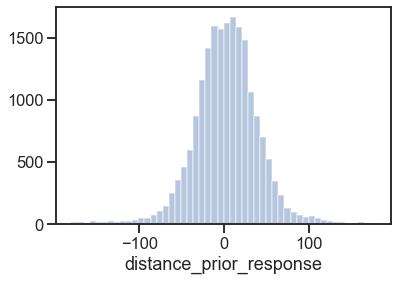

In [85]:
sns.distplot(df.distance_prior_response, kde=False)

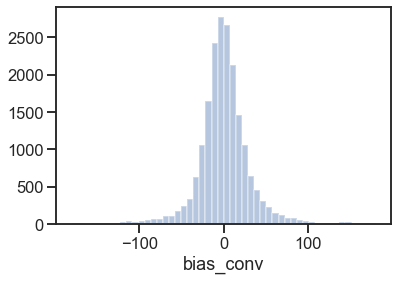

In [86]:
sns.distplot(df.bias_conv, kde=False)

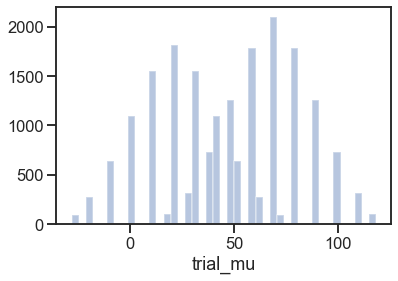

In [87]:
sns.distplot(df.trial_mu, kde=False)

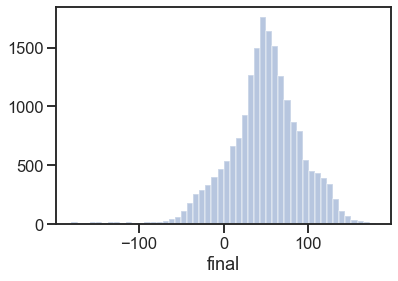

In [88]:
sns.distplot(df.final, kde=False)

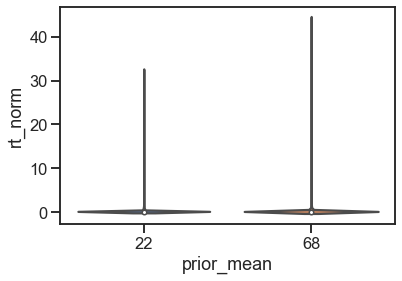

In [98]:
df = df.replace([np.inf, -np.inf], np.nan)
sns.violinplot(df.prior_mean, df.rt_norm, kde=False, data=df.dropna())

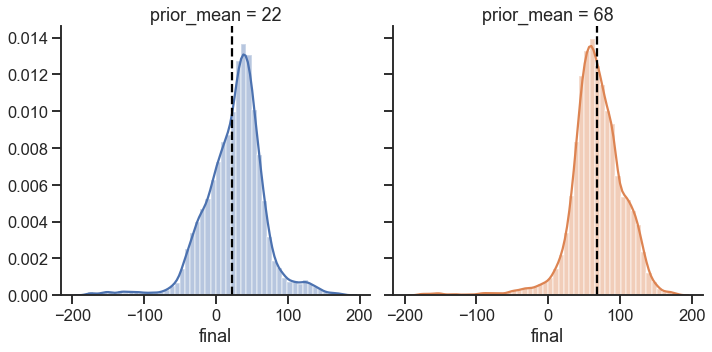

In [84]:
g = sns.FacetGrid(df, col="prior_mean", hue="prior_mean", height=5);

g.map(sns.distplot, "final");
ax = g.axes[0];
ax[0].axvline(22, ls='--', color='black')
ax[1].axvline(68, ls='--', color='black')

In [111]:
def f(df):
    d = {}
    d['group']= df
    d['rms_error'] = np.sqrt(np.mean(df.distance_prior_response**2))
    d['abs_error'] = np.mean(np.abs(df.distance_prior_response))
    return pd.Series(d)


error = df.groupby(['id', 'trial_sigma']).apply(f).reset_index()

error


,id,group,trial_sigma,rms_error,abs_error
0,1,ASD,10,28.577344,22.9440
1,1,ASD,40,77.896277,64.1360
2,1,TD,10,NaN,NaN
3,1,TD,40,NaN,NaN
4,3,ASD,10,33.514420,26.1035
5,3,ASD,40,93.131355,76.3795
6,3,TD,10,NaN,NaN
7,3,TD,40,NaN,NaN
8,4,ASD,10,27.000206,20.7660
9,4,ASD,40,30.715122,22.4385


In [ ]:

#Figures
ggboxplot(error, x = "trial_sigma", y = "rms_error", add= "jitter",color = "group",legend = "right", ylab="Root mean square error", xlab = "Variability" )  + scale_color_manual(values=c("darkorange", "darkslategrey"))

ggboxplot(error, x = "trial_sigma", y = "abs_error", color = "group", add= "jitter" ,legend = "right", ylab="Absolute error", xlab = "Variability" )+ scale_color_manual(values=c("darkorange", "darkslategrey"))


error<-df%>%
  group_by(id,trial_sigma, group, tr_100)%>%
  summarize(rms_error = sqrt(mean(distance_prior_response^2)), abs_error = mean(abs(distance_prior_response)))

#Summarytable of rms error and abslute error per group.
error %>%group_by(id,trial_sigma, group)%>%
      summarize(n = n(),rms_error = mean(rms_error), abs_error = mean(abs_error))%>%
      group_by(trial_sigma,group)%>%
      summarize(n=n(),rms_error = mean(rms_error), abs_error = mean(abs_error))

#Error per block of 100 trials
ggboxplot(error, x = "tr_100", y = "rms_error", color = "trial_sigma", add= "jitter",legend = "right", ylab="Root mean square error", xlab = "Blocks" ) + facet_grid(~group) + scale_color_manual(values=c("darkorange", "darkslategrey"))
ggboxplot(error, x = "tr_100", y = "abs_error", color = "trial_sigma", add= "jitter" ,legend = "right", ylab="Absolute error", xlab = "Blocks" )+ facet_grid(~group)+ scale_color_manual(values=c("darkorange", "darkslategrey"))

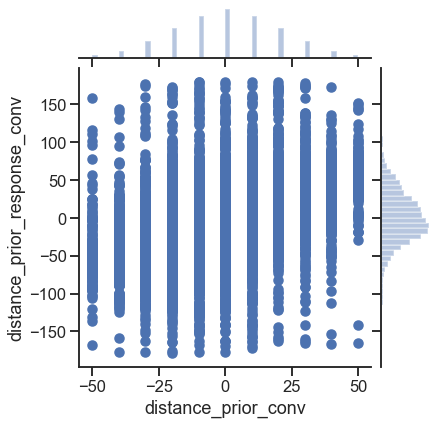

In [53]:
sns.jointplot(x="distance_prior_conv", y="distance_prior_response_conv", data=df);